<a href="https://colab.research.google.com/github/sakasa/AttendanceChatPost-ChromeExtension/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
response

<Response [200]>

In [4]:
# json文字列をdictへ
j_res = json.loads(response.text)
j_res.keys()

dict_keys(['contacts', 'querents', 'patients', 'patients_summary', 'discharges_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])

In [5]:
# 日毎の数
patients_count = [data['小計'] for data in j_res['patients_summary']['data']]

In [6]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [7]:
# 日付をインデックスにした日毎の数のデータフレーム
patients_df = pd.DataFrame(
    {'patients_count': patients_count},
    index=pd.date_range(
        start=utc_datestr_to_jst_date(j_res['patients_summary']['data'][0]['日付']),
        end=utc_datestr_to_jst_date(j_res['patients_summary']['data'][-1]['日付']),
        freq='D'))
patients_df['datetime'] = patients_df.index
patients_df.tail()

,patients_count,datetime
2020-08-17 17:00:00+09:00,161,2020-08-17 17:00:00+09:00
2020-08-18 17:00:00+09:00,207,2020-08-18 17:00:00+09:00
2020-08-19 17:00:00+09:00,186,2020-08-19 17:00:00+09:00
2020-08-20 17:00:00+09:00,339,2020-08-20 17:00:00+09:00
2020-08-21 17:00:00+09:00,258,2020-08-21 17:00:00+09:00


In [8]:
# 7日移動平均
seven_day_mov_ave = patients_df['patients_count'].rolling('7D').mean()
seven_day_mov_center_ave = patients_df['patients_count'].rolling(7, center=True).mean()
seven_day_mov_sum = patients_df['patients_count'].rolling('7D').sum()
patients_df['7d_mov_ave'] = seven_day_mov_ave
patients_df['7d_mov_center_ave'] = seven_day_mov_center_ave
patients_df['7d_mov_sum'] = seven_day_mov_sum
patients_df.tail()

,patients_count,datetime,7d_mov_ave,7d_mov_center_ave,7d_mov_sum
2020-08-17 17:00:00+09:00,161,2020-08-17 17:00:00+09:00,258.714286,275.285714,1811.0
2020-08-18 17:00:00+09:00,207,2020-08-18 17:00:00+09:00,261.428571,256.571429,1830.0
2020-08-19 17:00:00+09:00,186,2020-08-19 17:00:00+09:00,256.285714,NaN,1794.0
2020-08-20 17:00:00+09:00,339,2020-08-20 17:00:00+09:00,275.285714,NaN,1927.0
2020-08-21 17:00:00+09:00,258,2020-08-21 17:00:00+09:00,256.571429,NaN,1796.0


In [9]:
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
patients_df['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in patients_df.index]
patients_df.tail()

,patients_count,datetime,7d_mov_ave,7d_mov_center_ave,7d_mov_sum,week_num
2020-08-17 17:00:00+09:00,161,2020-08-17 17:00:00+09:00,258.714286,275.285714,1811.0,'20w34
2020-08-18 17:00:00+09:00,207,2020-08-18 17:00:00+09:00,261.428571,256.571429,1830.0,'20w34
2020-08-19 17:00:00+09:00,186,2020-08-19 17:00:00+09:00,256.285714,NaN,1794.0,'20w34
2020-08-20 17:00:00+09:00,339,2020-08-20 17:00:00+09:00,275.285714,NaN,1927.0,'20w34
2020-08-21 17:00:00+09:00,258,2020-08-21 17:00:00+09:00,256.571429,NaN,1796.0,'20w34


In [10]:
# 曜日の列をセット
patients_df['week_day'] = [d.strftime('%a') for d in patients_df.index]
patients_df.tail(15)

,patients_count,datetime,7d_mov_ave,7d_mov_center_ave,7d_mov_sum,week_num,week_day
2020-08-07 17:00:00+09:00,462,2020-08-07 17:00:00+09:00,345.142857,335.857143,2416.0,'20w32,Fri
2020-08-08 17:00:00+09:00,429,2020-08-08 17:00:00+09:00,339.000000,318.571429,2373.0,'20w32,Sat
2020-08-09 17:00:00+09:00,331,2020-08-09 17:00:00+09:00,344.571429,312.714286,2412.0,'20w32,Sun
2020-08-10 17:00:00+09:00,197,2020-08-10 17:00:00+09:00,335.857143,290.714286,2351.0,'20w33,Mon
2020-08-11 17:00:00+09:00,188,2020-08-11 17:00:00+09:00,318.571429,280.285714,2230.0,'20w33,Tue
2020-08-12 17:00:00+09:00,222,2020-08-12 17:00:00+09:00,312.714286,274.000000,2189.0,'20w33,Wed
2020-08-13 17:00:00+09:00,206,2020-08-13 17:00:00+09:00,290.714286,263.857143,2035.0,'20w33,Thu
2020-08-14 17:00:00+09:00,389,2020-08-14 17:00:00+09:00,280.285714,258.714286,1962.0,'20w33,Fri
2020-08-15 17:00:00+09:00,385,2020-08-15 17:00:00+09:00,274.000000,261.428571,1918.0,'20w33,Sat
2020-08-16 17:00:00+09:00,260,2020-08-16 17:00:00+09:00,263.857143,256.285714,1847.0,'20w33,Sun


In [11]:
# 週毎に集計
groupby_week_num = patients_df.groupby('week_num', as_index=True)

In [12]:
# 集計結果から平均と合計を取得しデータフレームにセット
week_num_df = pd.DataFrame({
    'week_num': patients_df['week_num'].unique(),
    'week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
week_num_df.tail()

,week_num,week_mean,week_sum
2020-07-26 17:00:00+09:00,'20w30,257.571429,1803
2020-08-02 17:00:00+09:00,'20w31,320.142857,2241
2020-08-09 17:00:00+09:00,'20w32,344.571429,2412
2020-08-16 17:00:00+09:00,'20w33,263.857143,1847
2020-08-21 17:00:00+09:00,'20w34,230.200000,1151


In [13]:
df = pd.concat([
                patients_df,
                week_num_df.loc[:, ['week_mean', 'week_sum']]
                ], axis=1)
df.tail(15)

,patients_count,datetime,7d_mov_ave,7d_mov_center_ave,7d_mov_sum,week_num,week_day,week_mean,week_sum
2020-08-07 17:00:00+09:00,462,2020-08-07 17:00:00+09:00,345.142857,335.857143,2416.0,'20w32,Fri,NaN,NaN
2020-08-08 17:00:00+09:00,429,2020-08-08 17:00:00+09:00,339.000000,318.571429,2373.0,'20w32,Sat,NaN,NaN
2020-08-09 17:00:00+09:00,331,2020-08-09 17:00:00+09:00,344.571429,312.714286,2412.0,'20w32,Sun,344.571429,2412.0
2020-08-10 17:00:00+09:00,197,2020-08-10 17:00:00+09:00,335.857143,290.714286,2351.0,'20w33,Mon,NaN,NaN
2020-08-11 17:00:00+09:00,188,2020-08-11 17:00:00+09:00,318.571429,280.285714,2230.0,'20w33,Tue,NaN,NaN
2020-08-12 17:00:00+09:00,222,2020-08-12 17:00:00+09:00,312.714286,274.000000,2189.0,'20w33,Wed,NaN,NaN
2020-08-13 17:00:00+09:00,206,2020-08-13 17:00:00+09:00,290.714286,263.857143,2035.0,'20w33,Thu,NaN,NaN
2020-08-14 17:00:00+09:00,389,2020-08-14 17:00:00+09:00,280.285714,258.714286,1962.0,'20w33,Fri,NaN,NaN
2020-08-15 17:00:00+09:00,385,2020-08-15 17:00:00+09:00,274.000000,261.428571,1918.0,'20w33,Sat,NaN,NaN
2020-08-16 17:00:00+09:00,260,2020-08-16 17:00:00+09:00,263.857143,256.285714,1847.0,'20w33,Sun,263.857143,1847.0


### グラフ出力

In [14]:
### 日毎の数
x = df.index
y1_1 = df['patients_count']
y1_2 = df['7d_mov_ave']
#y1_3 = df['7d_mov_center_ave']
y1_4 = df['week_mean']

In [15]:
### 週毎の数
#x2 = week_num_df['week_num']
#y2_1 = week_num_df['week_mean']
#y2_2 = week_num_df['week_sum']
y2_1 = df['7d_mov_sum']
y2_2 = df['week_sum']

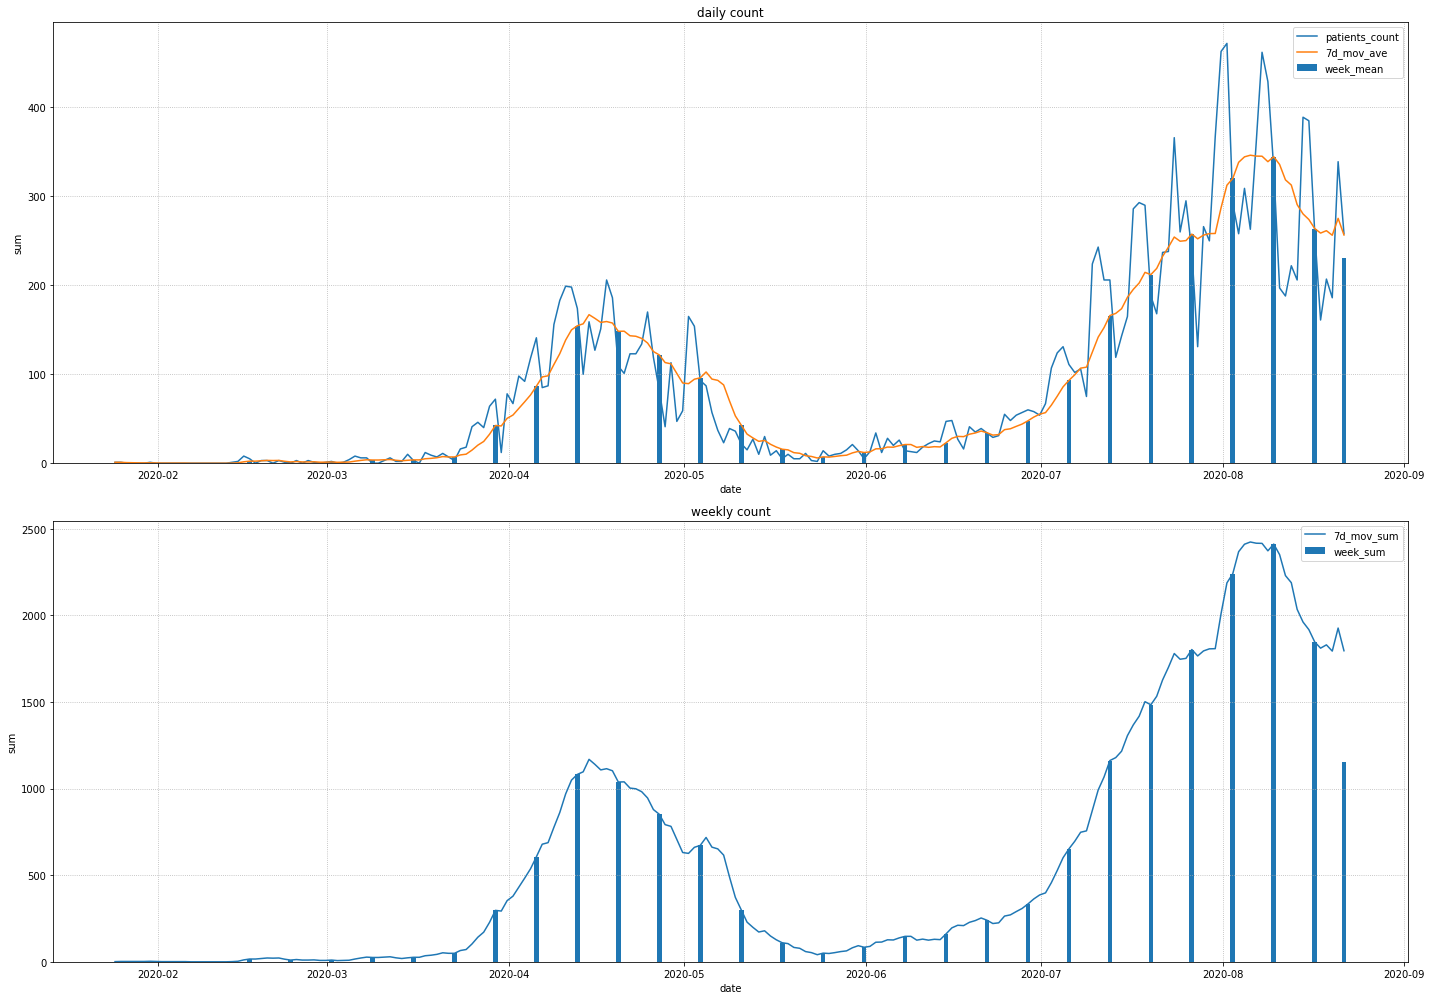

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(20, 14))

### 日毎の数
ax[0].set_title('daily count')
ax[0].set_xlabel('date')
ax[0].set_ylabel('sum')
ax[0].plot(x, y1_1, label='patients_count')
ax[0].plot(x, y1_2, label='7d_mov_ave')
#ax[0].plot(x, y1_3, label='7d_mov_center_ave')
ax[0].bar(x, y1_4, label='week_mean')
ax[0].grid(linestyle=':')
ax[0].legend()

### 週毎の平均
#ax[1].set_title('weekly mean')
#ax[1].set_xticklabels(labels=x2, rotation=90)
#ax[1].set_xlabel('week_num')
#ax[1].set_ylabel('mean')
#ax[1].plot(x2, y2_1, label='mean')
#ax[1].grid(linestyle=':')
#ax[1].legend()

### 週毎の合計
ax[1].set_title('weekly count')
ax[1].set_xlabel('date')
ax[1].set_ylabel('sum')
ax[1].plot(x, y2_1, label='7d_mov_sum')
ax[1].bar(x, y2_2, label='week_sum')
ax[1].grid(linestyle=':')
ax[1].legend()
#ax[1].set_title('weekly sum')
#ax[1].set_xticklabels(labels=x2, rotation=90)
#ax[1].set_xlabel('week_num')
#ax[1].set_ylabel('sum')
#ax[1].plot(x2, y2_2, label='sum')
#ax[1].grid(linestyle=':')
#ax[1].legend()

plt.tight_layout()

---

In [17]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [18]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [19]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [20]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [21]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df.index], # タイムスタンプ
    'year': np.array(df.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df['datetime'][0]).days for d in df['datetime']]
ds_df['passed'] = [(d - df.index[0]).days for d in df.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df.index]
# 日毎の数
ds_df['patients_count'] = df['patients_count']
# 7日間移動平均
ds_df['7d_mov_ave'] = df['7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df['7d_mov_center_ave']
# 7日間移動合計
ds_df['7d_mov_sum'] = df['7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,patients_count,7d_mov_ave,7d_mov_sum
196,1.596787e+09,2020,8,7,1,0,0,0,0,0,0,196,0,122,462,345.142857,2416.0
197,1.596874e+09,2020,8,8,0,0,1,0,0,0,0,197,0,123,429,339.000000,2373.0
198,1.596960e+09,2020,8,9,0,0,0,1,0,0,0,198,0,124,331,344.571429,2412.0
199,1.597046e+09,2020,8,10,0,1,0,0,0,0,0,199,0,125,197,335.857143,2351.0
200,1.597133e+09,2020,8,11,0,0,0,0,0,1,0,200,0,126,188,318.571429,2230.0
201,1.597219e+09,2020,8,12,0,0,0,0,0,0,1,201,0,127,222,312.714286,2189.0
202,1.597306e+09,2020,8,13,0,0,0,0,1,0,0,202,0,128,206,290.714286,2035.0
203,1.597392e+09,2020,8,14,1,0,0,0,0,0,0,203,0,129,389,280.285714,1962.0
204,1.597478e+09,2020,8,15,0,0,1,0,0,0,0,204,0,130,385,274.000000,1918.0
205,1.597565e+09,2020,8,16,0,0,0,1,0,0,0,205,0,131,260,263.857143,1847.0


In [22]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   timestamp       211 non-null    float64
 1   year            211 non-null    int64  
 2   month           211 non-null    int64  
 3   day             211 non-null    int64  
 4   Fri             211 non-null    uint8  
 5   Mon             211 non-null    uint8  
 6   Sat             211 non-null    uint8  
 7   Sun             211 non-null    uint8  
 8   Thu             211 non-null    uint8  
 9   Tue             211 non-null    uint8  
 10  Wed             211 non-null    uint8  
 11  passed          211 non-null    int64  
 12  emergency       211 non-null    int64  
 13  em_passed       211 non-null    int64  
 14  patients_count  211 non-null    int64  
 15  7d_mov_ave      211 non-null    float64
 16  7d_mov_sum      211 non-null    float64
dtypes: float64(3), int64(7), uint8(7)
m

In [23]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,patients_count,7d_mov_ave,7d_mov_sum
count,2.110000e+02,211.0,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.00000,211.000000,211.000000,211.000000,211.000000,211.000000
mean,1.588925e+09,2020.0,4.734597,15.658768,0.146919,0.142180,0.142180,0.142180,0.142180,0.142180,0.142180,105.00000,0.232227,44.151659,89.407583,85.904739,601.255924
std,5.275119e+06,0.0,2.036731,8.831608,0.354867,0.350065,0.350065,0.350065,0.350065,0.350065,0.350065,61.05462,0.423258,45.588174,111.182967,102.537534,717.827344
min,1.579853e+09,2020.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.584389e+09,2020.0,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,52.50000,0.000000,0.000000,5.000000,4.571429,32.000000
50%,1.588925e+09,2020.0,5.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.00000,0.000000,31.000000,37.000000,32.714286,229.000000
75%,1.593461e+09,2020.0,6.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,157.50000,0.000000,83.500000,147.000000,143.000000,1001.000000
max,1.597997e+09,2020.0,8.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,210.00000,1.000000,136.000000,472.000000,346.285714,2424.000000


In [24]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,patients_count,7d_mov_ave,7d_mov_sum
timestamp,1.000000,NaN,0.989818,-0.020921,0.000000,-0.003342,-0.016710,-0.010026,0.016710,0.003342,0.010026,1.000000,-0.063205,0.956292,0.685489,0.725375,0.725494
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,0.989818,NaN,1.000000,-0.162839,-0.005090,-0.000253,-0.013611,-0.006932,0.013104,-0.000253,0.013104,0.989818,-0.060736,0.944653,0.685842,0.723973,0.724106
day,-0.020921,NaN,-0.162839,1.000000,0.035825,-0.021199,-0.021199,-0.019658,0.023469,0.025009,-0.022739,-0.020921,0.002192,-0.015093,-0.072039,-0.065266,-0.065377
Fri,0.000000,NaN,-0.005090,0.035825,1.000000,-0.168953,-0.168953,-0.168953,-0.168953,-0.168953,-0.168953,0.000000,-0.006311,0.006269,0.099373,0.004294,0.004226
Mon,-0.003342,NaN,-0.000253,-0.021199,-0.168953,1.000000,-0.165746,-0.165746,-0.165746,-0.165746,-0.165746,-0.003342,0.001066,-0.004043,-0.110997,-0.003099,-0.003083
Sat,-0.016710,NaN,-0.013611,-0.021199,-0.168953,-0.165746,1.000000,-0.165746,-0.165746,-0.165746,-0.165746,-0.016710,0.001066,-0.015382,0.074726,-0.011011,-0.011061
Sun,-0.010026,NaN,-0.006932,-0.019658,-0.168953,-0.165746,-0.165746,1.000000,-0.165746,-0.165746,-0.165746,-0.010026,0.001066,-0.009712,-0.020827,-0.006128,-0.006134
Thu,0.016710,NaN,0.013104,0.023469,-0.168953,-0.165746,-0.165746,-0.165746,1.000000,-0.165746,-0.165746,0.016710,0.001066,0.013562,0.058943,0.010746,0.010789
Tue,0.003342,NaN,-0.000253,0.025009,-0.168953,-0.165746,-0.165746,-0.165746,-0.165746,1.000000,-0.165746,0.003342,0.001066,0.001626,-0.045541,0.000811,0.000840


In [25]:
!python -V

Python 3.6.9
